# Crypto Currency Analysis


In [44]:
!pip install pandas_datareader

In [45]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from pandas_datareader.data import DataReader

# Bitcoin

Bitcoin (₿) is a decentralized digital currency that can be transferred on the peer-to-peer bitcoin network.Bitcoin transactions are verified by network nodes through cryptography and recorded in a public distributed ledger called a blockchain.
1 Bitcoin(as of today) = 23,26,790(Rs)

In [46]:
#bitcoin data
btc = pd.read_csv("Bitcoin.csv",sep = ",")
btc.head(5)

,Date,Open,High,Low,Close,Volume,Market Cap
0,27-06-2021,32287.523211,34656.127356,32071.757148,34649.644588,3.551164e+10,6.494617e+11
1,26-06-2021,31594.663571,32637.587193,30184.501794,32186.277671,3.858539e+10,6.032760e+11
2,25-06-2021,34659.104499,35487.248003,31350.883858,31637.780055,4.023090e+10,5.929782e+11
3,24-06-2021,33682.800404,35228.852611,32385.214696,34662.435894,3.312337e+10,6.496440e+11
4,23-06-2021,32515.714303,34753.408503,31772.632355,33723.028978,4.631711e+10,6.320113e+11


In [78]:
#finding maximum value of bitcoin
btcmax=btc[btc['Close']==max(btc.Close)]
print(" The highest value of bitcoin")
btcmax


 The highest value of bitcoin


,Date,Open,High,Low,Close,Volume,Market Cap,Daily Return
1289,16-12-2017,17760.300781,19716.699219,17515.300781,19497.400391,1.274060e+10,3.265025e+11,0.01863


In [48]:
#learning about stats of bitcoin data(like mean,std etc..)
btc.describe()

,Open,High,Low,Close,Volume,Market Cap
count,2983.000000,2983.000000,2983.000000,2983.000000,2.983000e+03,2.983000e+03
mean,6613.843852,6805.260516,6402.037782,6625.160672,1.084006e+10,1.192478e+11
std,11199.197921,11553.544329,10781.352553,11209.848478,1.887826e+10,2.092413e+11
min,68.504997,74.561096,65.526001,68.431000,0.000000e+00,7.784112e+08
25%,429.792999,435.968491,421.852005,429.862000,3.013725e+07,6.294347e+09
50%,2191.560059,2303.899902,2071.989990,2202.419922,9.174120e+08,3.601766e+10
75%,8494.818022,8687.633944,8230.187652,8500.334961,1.575577e+10,1.488823e+11
max,63523.754869,64863.098908,62208.964366,63503.457930,3.509679e+11,1.186364e+12


In [49]:
#info about bitcoin data(memory usage,data types etc..)
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2983 entries, 0 to 2982
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2983 non-null   object 
 1   Open        2983 non-null   float64
 2   High        2983 non-null   float64
 3   Low         2983 non-null   float64
 4   Close       2983 non-null   float64
 5   Volume      2983 non-null   float64
 6   Market Cap  2983 non-null   float64
dtypes: float64(6), object(1)
memory usage: 163.3+ KB


In [50]:
#checing empty values in bitcoin data
btc.isna().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64

# Dogecoin


Dogecoin is a cryptocurrency created by software engineers Billy Markus and Jackson Palmer, who decided to create a payment system as a "joke", making fun of the wild speculation in cryptocurrencies at the time.
1 Dogecoin(as of today) = 6.67(Rs)

In [51]:
#dogecoin data
doge = pd.read_csv("Meme Coin/Dogecoin.csv",sep = ",")
doge.head(5)

,Date,Open,High,Low,Close,Volume,Market Cap
0,27-06-2021,0.246045,0.266891,0.240894,0.264450,2.167522e+09,3.443160e+10
1,26-06-2021,0.237673,0.255127,0.230972,0.244784,2.649457e+09,3.186753e+10
2,25-06-2021,0.263480,0.289145,0.230006,0.239153,5.542163e+09,3.113117e+10
3,24-06-2021,0.234970,0.268690,0.222527,0.262782,3.844648e+09,3.420559e+10
4,23-06-2021,0.190671,0.247110,0.180979,0.232174,5.098675e+09,3.021735e+10


In [79]:
#finding maximum value of dogecoin
dogemax=doge[doge['Close']==max(doge.Close)]
print(" The highest value of dogecoin")
dogemax

 The highest value of dogecoin


,Date,Open,High,Low,Close,Volume,Market Cap,Daily Return
1267,07-01-2018,0.014673,0.018773,0.014577,0.017088,288184000.0,1.925383e+09,0.135773


In [53]:
#learning about stats of dogecoin data(like mean,std etc..)
doge.describe()

,Open,High,Low,Close,Volume,Market Cap
count,2752.000000,2752.000000,2752.000000,2752.000000,2.752000e+03,2.752000e+03
mean,0.012891,0.014171,0.011652,0.012995,4.286633e+08,1.660441e+09
std,0.060946,0.067809,0.054061,0.061207,2.810452e+09,7.937786e+09
min,0.000087,0.000089,0.000085,0.000087,0.000000e+00,1.509085e+06
25%,0.000226,0.000231,0.000222,0.000226,2.525640e+05,2.336210e+07
50%,0.001824,0.001909,0.001750,0.001824,5.405195e+06,2.113453e+08
75%,0.002882,0.002965,0.002785,0.002881,5.016303e+07,3.472437e+08
max,0.687801,0.737567,0.608168,0.684777,6.941068e+10,8.868082e+10


In [54]:
#info about dogecoin data(memory usage,data types etc..)
doge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2752 non-null   object 
 1   Open        2752 non-null   float64
 2   High        2752 non-null   float64
 3   Low         2752 non-null   float64
 4   Close       2752 non-null   float64
 5   Volume      2752 non-null   float64
 6   Market Cap  2752 non-null   float64
dtypes: float64(6), object(1)
memory usage: 150.6+ KB


In [55]:
#checing empty values in dogecoin data
doge.isna().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64

# Bitconnect

Bitconnect (also spelled BitConnect and stylized bitconnect, ticker code BCC) was an open-source cryptocurrency that was connected with a high-yield investment program, a type of Ponzi scheme.
After the platform administrators closed the earning platform on January 16, 2018, and refunded the users' investments in BCC following a 92% coin value crash, confidence was lost and the value of the coin plummeted to below $1 from a previous high of nearly $525.

1 Bitconnect(as of today) = 52.91(Rs)

In [56]:
#bitconnect data
bit = pd.read_csv("Dead Coin/bitconnect.csv",sep = ",")
bit.head(5)

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Volume(BCC)
0,0,21-05-2021,2.20,2.27,1.84,2.01,0.00,0.00
1,1,20-05-2021,2.01,2.28,1.91,2.19,0.00,0.00
2,2,19-05-2021,2.31,2.34,1.68,2.01,0.00,0.00
3,3,18-05-2021,2.19,2.50,2.18,2.32,18.81,8.01
4,4,17-05-2021,2.25,2.30,2.06,2.19,4.26,1.92


In [80]:
#finding maximum value of bitconnect
bitmax=bit[bit['Close']==max(bit.Close)]
print(" The highest value of bitconnect")
bitmax

 The highest value of bitconnect


,Unnamed: 0,Date,Open,High,Low,Close,Volume,Volume(BCC),Daily Return
1237,1237,31-12-2017,413.53,470.86,407.8,463.31,41366100.0,94254.86,0.204779


In [58]:
#learning about stats of bitconnect data(like mean,std etc..)
bit.describe()

,Unnamed: 0,Open,High,Low,Close,Volume,Volume(BCC)
count,1581.000000,1581.000000,1581.000000,1581.000000,1581.000000,1.581000e+03,1.581000e+03
mean,790.000000,26.850618,30.741569,25.025758,26.869104,1.975618e+06,2.312771e+04
std,456.539703,77.998132,92.838834,72.600288,78.040337,6.623278e+06,6.395393e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,395.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
50%,790.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
75%,1185.000000,1.890000,2.150000,1.760000,1.890000,4.978500e+04,2.832717e+04
max,1580.000000,461.940000,928.170000,425.810000,463.310000,8.964920e+07,1.377810e+06


In [59]:
#info about bitconnect data(memory usage,data types etc..)
bit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581 entries, 0 to 1580
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1581 non-null   int64  
 1   Date         1581 non-null   object 
 2   Open         1581 non-null   float64
 3   High         1581 non-null   float64
 4   Low          1581 non-null   float64
 5   Close        1581 non-null   float64
 6   Volume       1581 non-null   float64
 7   Volume(BCC)  1581 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 98.9+ KB


In [60]:
#checing empty values in bitconnect data
bit.isna().sum()

Unnamed: 0     0
Date           0
Open           0
High           0
Low            0
Close          0
Volume         0
Volume(BCC)    0
dtype: int64

# Ethereum


Ethereum is a decentralized, open-source blockchain with smart contract functionality. Ether is the native cryptocurrency of the platform. Among cryptocurrencies, Ether is second only to Bitcoin in market capitalization.
1 Ethereum(as of today) = 1,56,532(Rs)

In [81]:
#Ethereum data
ether = pd.read_csv("Ethereum.csv",sep = ",")
ether.head(5)


,Date,Open,High,Low,Close,Volume,Market Cap
0,27-06-2021,1830.996918,1979.958125,1811.245864,1978.894662,1.988547e+10,2.304736e+11
1,26-06-2021,1810.884253,1850.179779,1719.559464,1829.239217,2.063754e+10,2.130212e+11
2,25-06-2021,1989.215789,2017.759464,1794.400424,1813.217232,2.277433e+10,2.111311e+11
3,24-06-2021,1968.957423,2032.339389,1887.432046,1988.456276,2.027285e+10,2.315093e+11
4,23-06-2021,1878.625034,2043.530443,1827.571482,1989.736271,2.840866e+10,2.316253e+11


In [82]:
#finding maximum value of ethereum
ethermax=ether[ether['Close']==max(ether.Close)]
print(" The highest value of Ethereum")
ethermax

 The highest value of Ethereum


,Date,Open,High,Low,Close,Volume,Market Cap
47,11-05-2021,3948.271909,4178.208815,3783.889474,4168.701049,5.267974e+10,4.828819e+11


In [63]:
#learning about stats of ethereum data(like mean,std etc..)
ether.describe()

,Open,High,Low,Close,Volume,Market Cap
count,2152.000000,2152.000000,2152.000000,2152.000000,2.152000e+03,2.152000e+03
mean,375.238311,390.268097,358.168960,376.115309,6.983742e+09,4.080111e+10
std,589.609942,617.541621,556.448912,590.536352,1.060661e+10,6.780152e+10
min,0.431589,0.482988,0.420897,0.434829,1.021280e+05,3.221363e+07
25%,13.677825,14.108875,13.137275,13.722550,3.801820e+07,1.128742e+09
50%,197.506358,204.124801,190.717165,197.480003,2.130523e+09,2.062268e+10
75%,383.993494,393.923044,371.323083,384.573336,9.403577e+09,4.170124e+10
max,4174.635873,4362.350542,3785.848603,4168.701049,8.448291e+10,4.828819e+11


In [64]:
#learning about stats of ethereum data(like mean,std etc..)
ether.describe()

,Open,High,Low,Close,Volume,Market Cap
count,2152.000000,2152.000000,2152.000000,2152.000000,2.152000e+03,2.152000e+03
mean,375.238311,390.268097,358.168960,376.115309,6.983742e+09,4.080111e+10
std,589.609942,617.541621,556.448912,590.536352,1.060661e+10,6.780152e+10
min,0.431589,0.482988,0.420897,0.434829,1.021280e+05,3.221363e+07
25%,13.677825,14.108875,13.137275,13.722550,3.801820e+07,1.128742e+09
50%,197.506358,204.124801,190.717165,197.480003,2.130523e+09,2.062268e+10
75%,383.993494,393.923044,371.323083,384.573336,9.403577e+09,4.170124e+10
max,4174.635873,4362.350542,3785.848603,4168.701049,8.448291e+10,4.828819e+11


In [65]:
#checing empty values in ethereum data
ether.isna().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64

# Data Visualisation

#Returns


In [66]:
def to2018(df):
    df18=equalize(df,bit)
    return df18.iloc[:len(bit)]

def equalize(df,dfs):
    low=len(dfs)
    high=len(df)
    dff=high-low
    
    return df.iloc[dff:]

In [67]:
btc18=to2018(btc)
ether18=to2018(ether)
crypto=["Bitcoin 2018","Bitcoin","Ethereum 2018","Ethereum","Bitconnect 2018","Dogecoin"]
cryptoDf=[btc18,btc,ether18,ether,bit,doge]

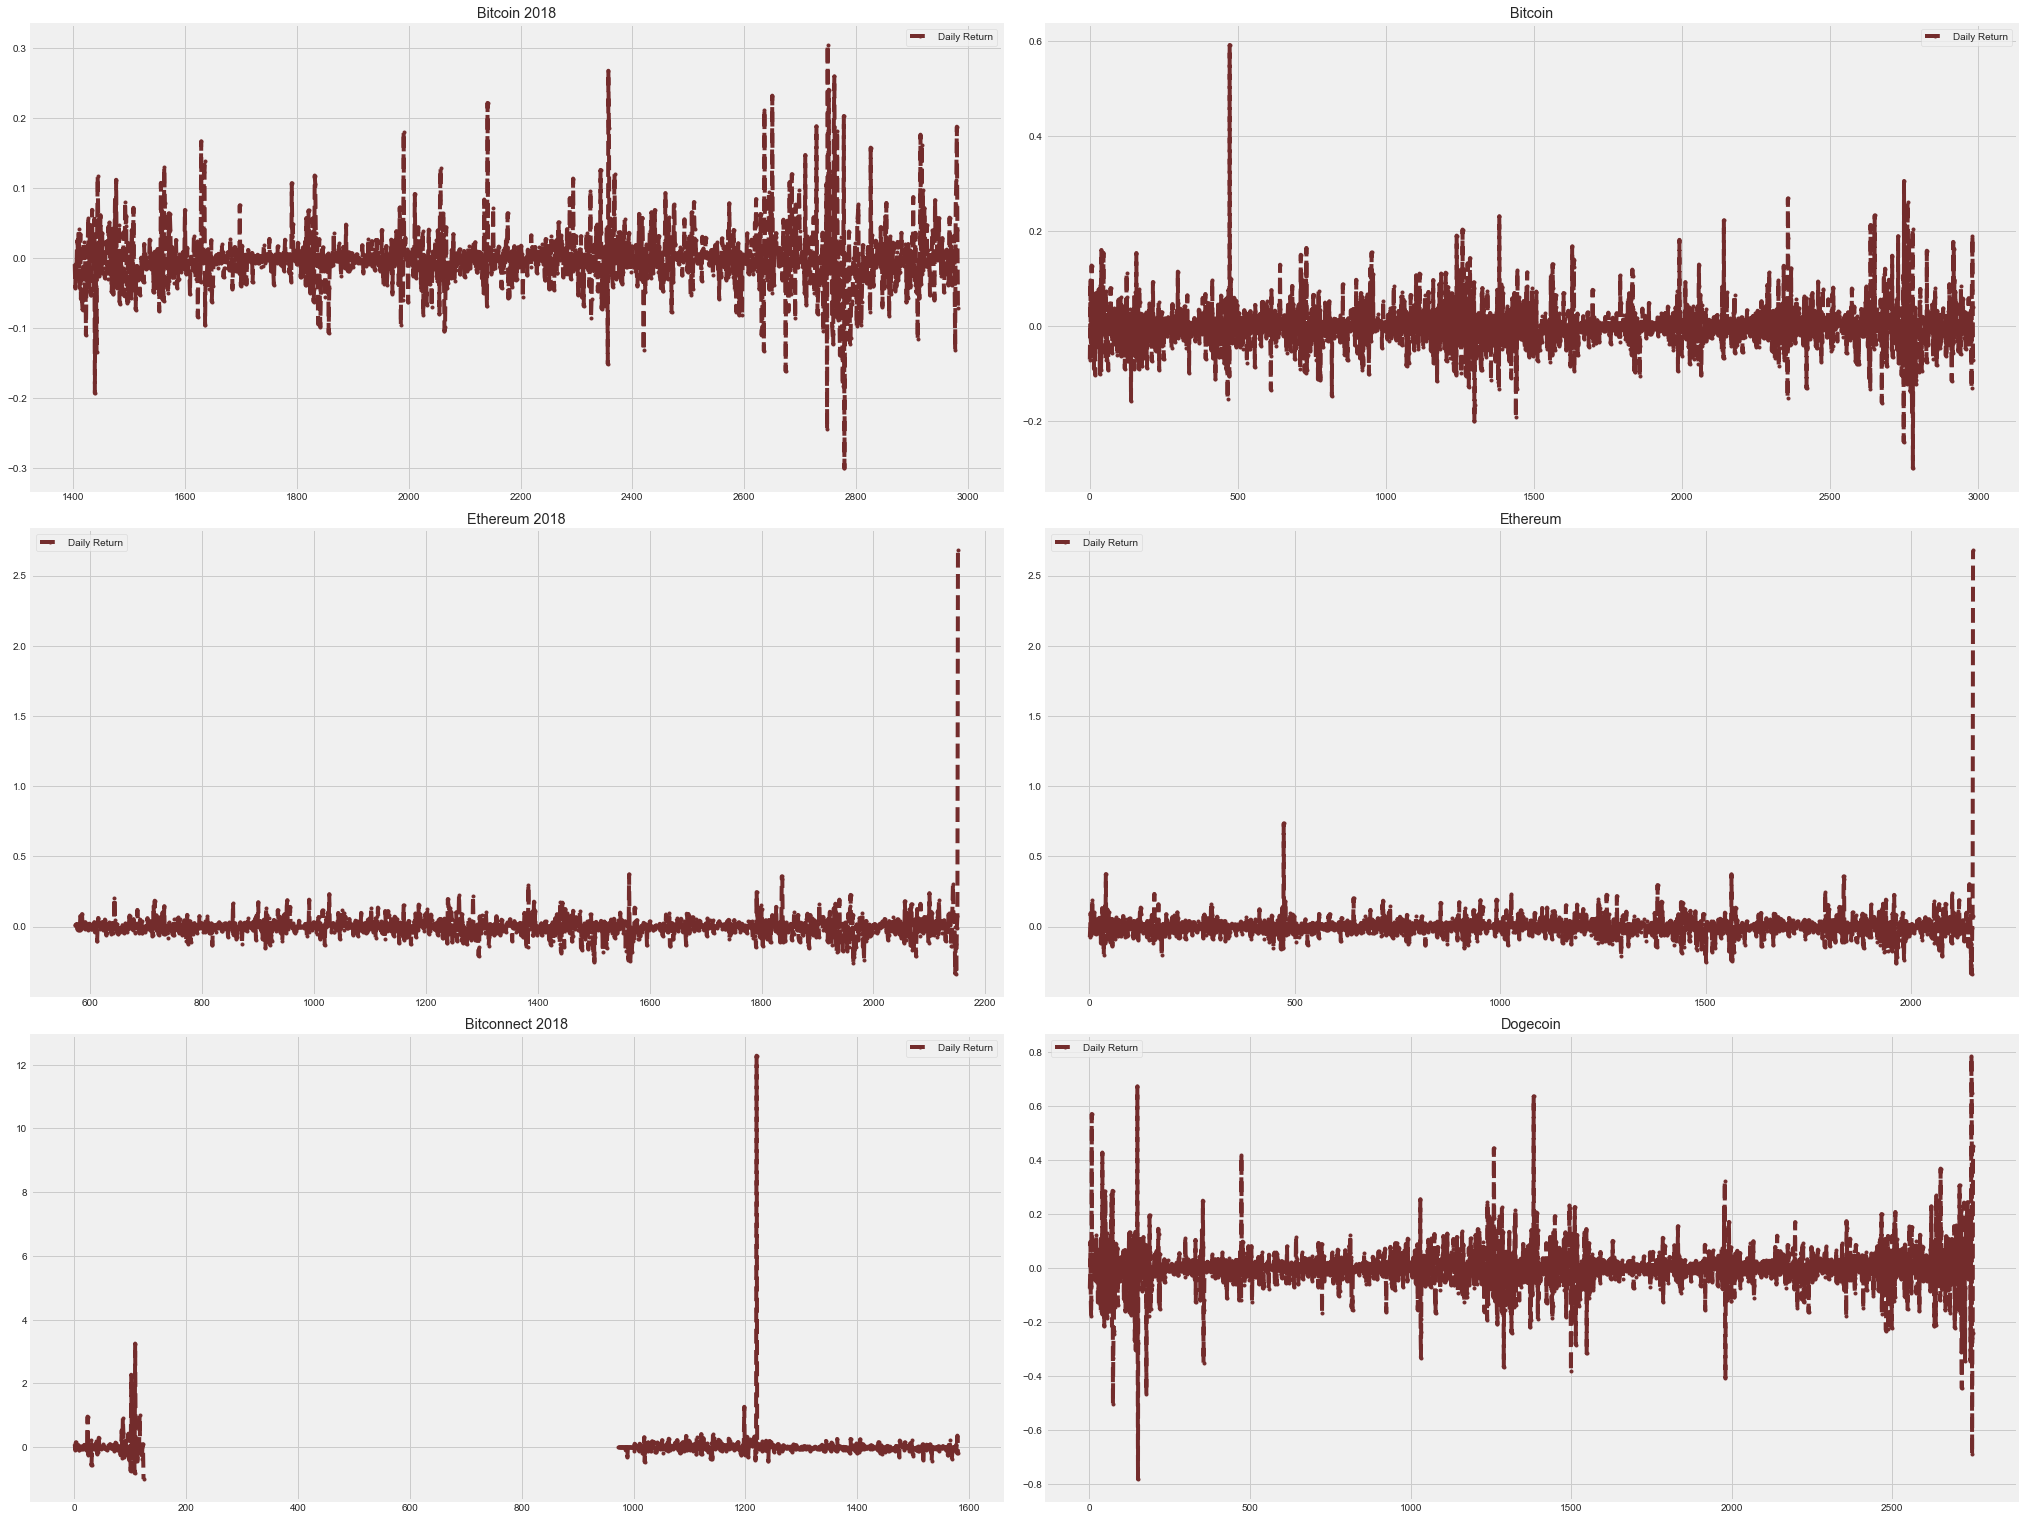

In [68]:
num_plots = 6
total_cols = 2
total_rows = 3
for df in cryptoDf:
    df['Daily Return'] = df['Close'].pct_change()
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(14*total_cols, 7*total_rows), constrained_layout=True)
for i, var in enumerate(crypto):
    row = i//total_cols
    pos = i % total_cols
    cryptoDf[i]['Daily Return'].plot(ax=axs[row][pos], legend=True,color='#732C2C', linestyle='--', marker='.')
    axs[row][pos].set_title(crypto[i])

Conclusion- The following plots depicts the return in the stock market of respective currencies, which in turn informs us about the percentage change in price of each currency. 
From the given plot we observer that the daily return in currency of ethereum and bitcoin was uneven in 2018, but according to 2020 stats it has imrproved and hence become even leading uniformity.

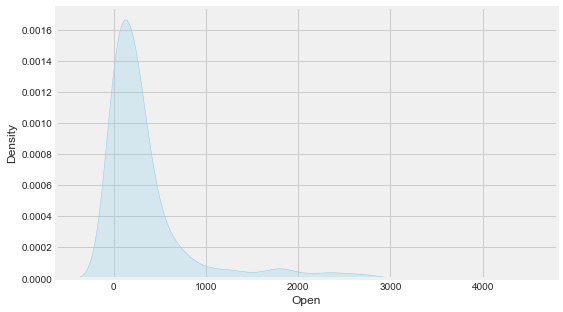

In [84]:
#Etherum mountain graph to visualise market prices and share movements
plt.figure(figsize=(8,5))
sns.kdeplot(data=ether.Open,fill=True,color="skyblue")
plt.show()

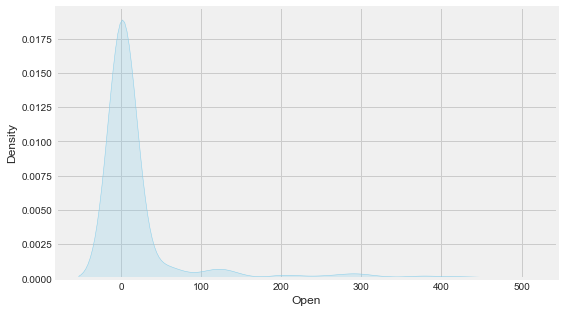

In [86]:
#Bitconnect mountain graph to visualise market prices and share movements
plt.figure(figsize=(8,5))
sns.kdeplot(data=bit.Open,fill=True,color="skyblue")
plt.show()

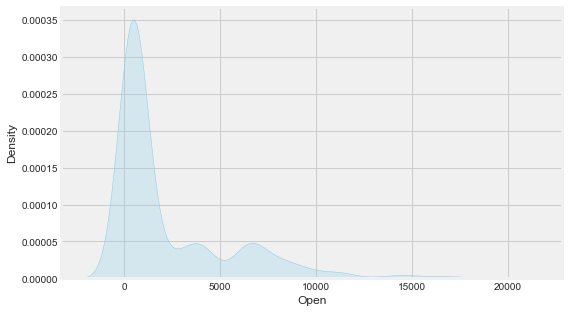

In [87]:
#Bitcoin mountain graph to visualise market prices and share movements
plt.figure(figsize=(8,5))
sns.kdeplot(data=btc.Open,fill=True,color="skyblue")
plt.show()

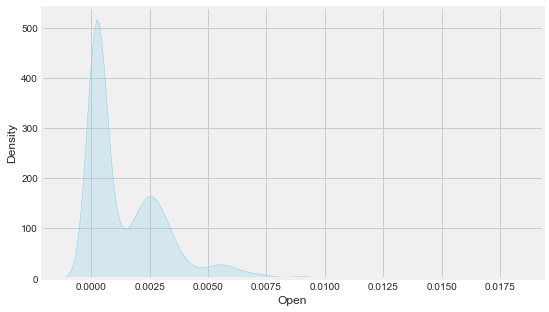

In [88]:
#Dogecoin mountain graph to visualise market prices and share movements
plt.figure(figsize=(8,5))
sns.kdeplot(data=doge.Open,fill=True,color="skyblue")
plt.show()

# Correlation

In [69]:
closeDf18=pd.DataFrame()
closeDf18['btc']=btc18['Close']
closeDf18['eth']=ether18['Close']
closeDf18['bit']=bit['Close']
returns18 = closeDf18.pct_change()
returns18.head()

,btc,eth,bit
1402,NaN,NaN,NaN
1403,-0.008445,-0.018993,-0.134078
1404,-0.042255,-0.024852,-0.072425
1405,-0.012285,-0.008611,0.245905
1406,-0.024090,0.021621,0.037997


In [70]:
btc=equalize(btc,ether)
doge=equalize(doge,ether)


closeDf=pd.DataFrame()
closeDf['btc']=btc['Close']
closeDf['ether']=ether['Close']
closeDf['doge']=doge['Close']


returns = closeDf.pct_change()
returns.head()

,btc,ether,doge
831,NaN,NaN,NaN
832,-0.009502,-0.008145,-0.003845
833,-0.001805,0.004491,-0.001064
834,0.005837,0.017126,-0.001594
835,-0.021689,-0.033051,-0.014051


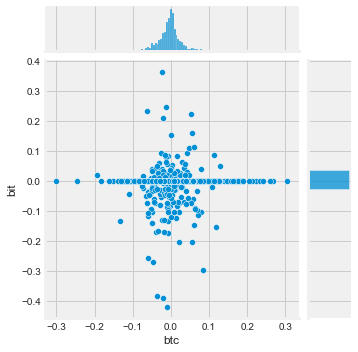

In [71]:
sns.jointplot(data=returns18, x='btc', y="bit", kind='scatter',height=5)
plt.show()

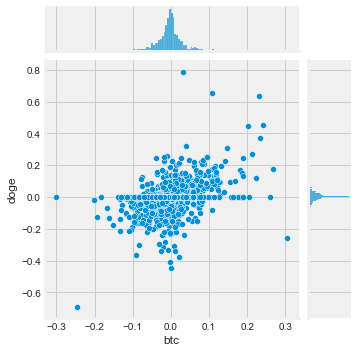

In [72]:
sns.jointplot(data=returns, x='btc', y="doge", kind='scatter',height=5)
plt.show()

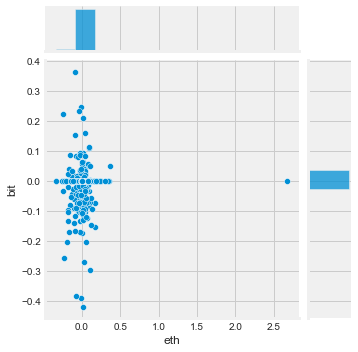

In [73]:
sns.jointplot(data=returns18, x='eth', y="bit", kind='scatter',height=5)
plt.show()

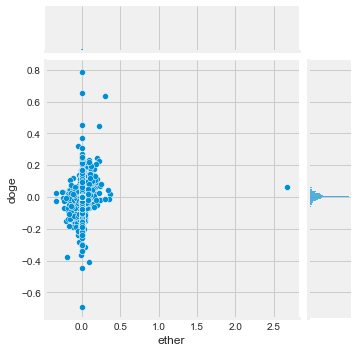

In [74]:
sns.jointplot(data=returns, x='ether', y='doge', kind='scatter',height=5)
plt.show()

Conclusion-The graph depicts that although bitconnect had very high returns compared to bitcoin or Ethereum, but it was that much risky to invest money in bitconnect.

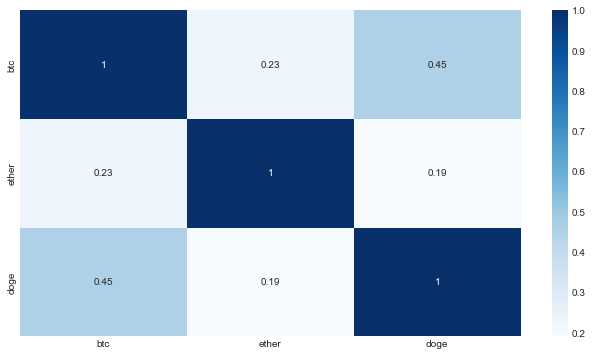

In [75]:
plt.figure(figsize=(10,6))
sns.heatmap(returns.corr(), annot=True, cmap="Blues")
plt.show()

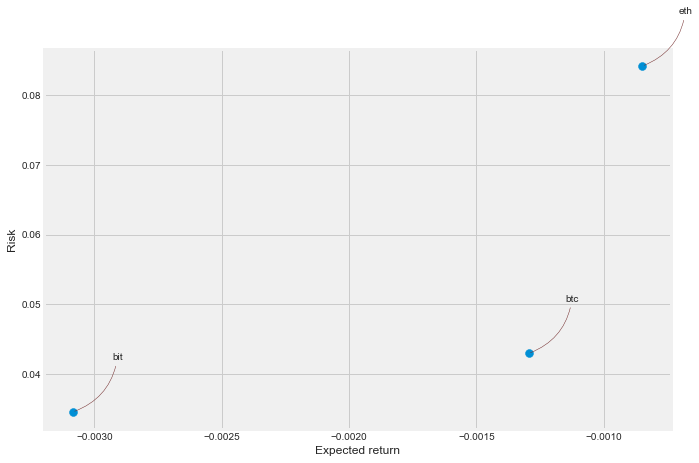

In [76]:
rets = returns18.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 7))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='#732C2C', connectionstyle='arc3,rad=-0.3'))

Conclusion-The graph indicates that although bitconnect had very high returns compared to bitcoin or Ethereum, but it was that much risky to invest money in bitconnect.
The value of bitconnect goes suddenly up and down and hence it is a risky stock to invest.

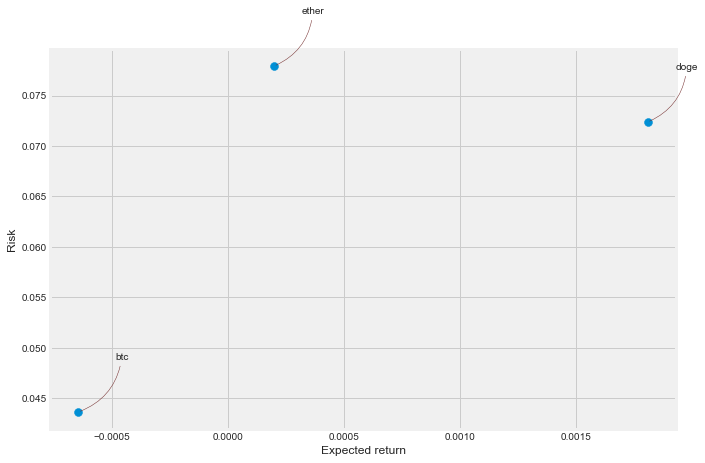

In [77]:
rets = returns.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 7))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='#732C2C', connectionstyle='arc3,rad=-0.3'))

Conclusion- The dogecoin was also as risky as bitconnect in the past

From the graphs we can clearly observe that Ethereum, and Bitcoin are quite a lot safer than Dogecoin and Bitconnect.The reason is why they are surviving the fall in 2018 and will survive through current dip in price too. The fall of dogecoin is inevitable. Although Dogecoin is not a scam. But the cultural structure of dogecoin digs a grave for itself.